# 0. Preparation

## Mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
if 'google.colab' in str(get_ipython()):
  IN_COLLAB = True
else:
  IN_COLLAB = False

#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
# MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH =  "/content/drive/MyDrive/TFT_baseline"

In [3]:
# # Clone Git to GDrive
# os.chdir('/content/drive/MyDrive/W210/')
# !git config --global user.name jcalz23
# !git config --global user.email "j.calzaretta.ai@gmail.com"
# !git clone https://github.com/jcalz23/co2-flux-hourly-gpp-modeling.git

#### (pip install)

In [4]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 44.6 MB/s eta 0:00:00


In [5]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 12.0 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=9e0986842972d17fb76417c467a1e328f27e36743

In [6]:
! pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# This is must in order to avoid error 
!pip install pytorch_lightning==1.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 41.6 MB/s eta 0:00:00
  Attempting uninstall: pytorch_lightning
    Found existing installation: pytorch-lightning 1.9.4
    Uninstalling pytorch-lightning-1.9.4:
      Successfully uninstalled pytorch-lightning-1.9.4


numba may potentially needed later

In [8]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install azure.storage.blob 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.8/387.8 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 KB 15.1 MB/s eta 0:00:00


## Import libraries

In [10]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
sys.path.append('./.cred')
sys.path.append('./code/src/tools')
sys.path.append('./code/src/tools/CloudIO')

from azure.storage.blob import BlobServiceClient
from AzStorageClient import AzStorageClient
# from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

# Load data from Azure blob

In [15]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + 'tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + 'cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

In [16]:
# AzStorageClient.listBlobs(container)
container = "baseline-data"
cred_file = az_cred_file
ext = "parquet"

# Container and file name
blob_name_train = "baseline-train-v-1-i-knn.parquet"
blob_name_val = "baseline-test-v-1-i-knn.parquet"

In [17]:
if os.path.exists(cred_file):
  connect_str = ""
  with open(cred_file, "rb") as f:
      data = json.load(f)
      connect_str = data['connectionstr']
      blob_svc_client = BlobServiceClient.from_connection_string(connect_str)
      tokens = connect_str.split(';')
      for t in tokens:
        if "AccountName=" in t:
          AccountName = t[len("AccountName="):]
        elif "AccountKey=" in t:
          AccountKey = t[len("AccountKey="):]

In [18]:
# Download train file
train_df = None
if not (os.path.exists(tmp_dir+blob_name_train)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name_train)
    train_df = pd.read_parquet(file_stream, engine='pyarrow')
    train_df.to_parquet(tmp_dir + blob_name_train)
else:
    train_df = pd.read_parquet(tmp_dir + blob_name_train)


# Load Test Data
test_df = None
if not (os.path.exists(tmp_dir+blob_name_val)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name_val)
    test_df = pd.read_parquet(file_stream, engine='pyarrow')
    test_df.to_parquet(tmp_dir + blob_name_val)
else:
    test_df = pd.read_parquet(tmp_dir + blob_name_val)

print(f"Train size: {train_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (631032, 49)
Test size: (234888, 49)


# Data Preprocessing
For development, subsetting to a few sites, and ~300 days for each site

In [19]:
train_sites = ['CH-Lae','FR-Pue','IT-Lav','US-ARM','US-NR1','US-SRM','US-Ton',
               'US-UMB','US-Var','US-Vcp','US-Wkg']#['CH-Lae', 'FR-Pue']
val_sites = ['ES-LJu', 'FI-Hyy']

# Subset train_df to save some time
print(f"Initial Train Sites: {train_df['site_id'].unique()}")
print(f"Initial num train timesteps: {len(train_df)}")
val_df_split1 = train_df.loc[train_df['site_id'].isin(val_sites), ].copy()
train_df = train_df.loc[train_df['site_id'].isin(train_sites), ].copy()
print(f"Trimmed Train Sites: {train_df['site_id'].unique()}")
print(f"Val Sites: {val_df_split1['site_id'].unique()}")
print(f"Test Sites: {test_df['site_id'].unique()}")

# Subset the time series within sites to save more time (300 days)
train_df = train_df.loc[train_df['timestep_idx_global'] < 300, ].copy()
print(f"Subset num train timesteps: {len(train_df)}")
val_df_split1 = val_df_split1.loc[val_df_split1['timestep_idx_global'] < 300, ].copy()
print(f"Subset num val timesteps: {len(val_df_split1)}")

Initial Train Sites: ['CH-Lae' 'ES-LJu' 'FI-Hyy' 'FR-Pue' 'IT-Lav' 'US-ARM' 'US-NR1' 'US-SRM'
 'US-Ton' 'US-UMB' 'US-Var' 'US-Vcp' 'US-Wkg']
Initial num train timesteps: 631032
Trimmed Train Sites: ['CH-Lae' 'FR-Pue' 'IT-Lav' 'US-ARM' 'US-NR1' 'US-SRM' 'US-Ton' 'US-UMB'
 'US-Var' 'US-Vcp' 'US-Wkg']
Val Sites: ['ES-LJu' 'FI-Hyy']
Test Sites: ['CA-Cbo' 'ES-LM2' 'FR-Lam' 'US-AR1' 'US-GLE' 'US-Seg']
Subset num train timesteps: 3300
Subset num val timesteps: 600


In [20]:
# Convert Dtypes
cat_cols = ["year", "month", "day", "hour", "IGBP", "koppen_main", "koppen_sub"]
for col in cat_cols:
  train_df[col] = train_df[col].astype(str).astype("category")
  val_df_split1[col] = val_df_split1[col].astype(str).astype("category")
  test_df[col] = test_df[col].astype(str).astype("category")

## Initialize TS Dataset

In [21]:
# (data is already splited to train/validation set)
max_prediction_length = 1 #24
max_encoder_length = 24*7

In [22]:
# John's setting
training = TimeSeriesDataSet(
    train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
    time_idx="timestep_idx_global",
    target="GPP_NT_VUT_REF",
    group_ids=["site_id"],
    allow_missing_timesteps=False, # <---- turned off bc gaps are filled
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["IGBP","koppen_main","koppen_sub"],
    static_reals=[], #elevation lat long
    time_varying_known_categoricals=["year", "month", "day", "hour"],
    time_varying_known_reals=["timestep_idx_global", 'TA_ERA', 'SW_IN_ERA', 
                              'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI',
       'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',  'BESS-PAR',
       'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm',
       'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
    time_varying_unknown_categoricals=[], 
    time_varying_unknown_reals=["GPP_NT_VUT_REF"],
    target_normalizer=None, # <---- not sure if we need this given we scale in data pipeline.... but might want to change to scale at Group level?
    categorical_encoders={'IGBP': NaNLabelEncoder(add_nan=True),
                          'koppen_main': NaNLabelEncoder(add_nan=True),
                          'koppen_sub': NaNLabelEncoder(add_nan=True),
                          'year': NaNLabelEncoder(add_nan=True), # temp for subset
                          'month': NaNLabelEncoder(add_nan=True), # temp for subset
                          'day': NaNLabelEncoder(add_nan=True), # temp for subset
                          },
    add_relative_time_idx=True,
    add_target_scales=False, # <------- turned off
    add_encoder_length=False, # <------- turned off
)

# create validation set (predict=True) using the full site sequence for val sites
validation = TimeSeriesDataSet.from_dataset(training, val_df_split1, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 2  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0) # <--- removed the batch_size*10

In [23]:
# create validation set (predict=True) using the full site sequence for val sites
validation = TimeSeriesDataSet.from_dataset(training, val_df_split1, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=0) # <--- removed the batch_size*10

# Create "Baseline" model 

### (Reference on "baseline":\)

- Baseline model that uses last known target value to make prediction.

https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.baseline.Baseline.html#pytorch_forecasting.models.baseline.Baseline

In [24]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1.2041285037994385

# Temporal Fusion Transformer

### Optimize learning rate (we could use this during the hyper parameter tuning)

In [25]:
# # configure network and trainer
# pl.seed_everything(42)
# trainer = pl.Trainer(
#     gpus=1,
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=0.1,
# )

# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.03,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     attention_head_size=1, #Set to up to 4 for large datasets
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=8,  # set to <= hidden_size
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     reduce_on_plateau_patience=4, # reduce learning rate if no improvement in validation loss after x epochs
#     optimizer="adam"
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=5e-2,
#     min_lr=1e-5,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

## Train TFT

In [26]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    attention_head_size=1, #Set to up to 4 for large datasets
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    logging_metrics=nn.ModuleList([MAE(), RMSE()]), #SMAPE(), #MAPE() #<---- added metrics to report in TensorBoard
    reduce_on_plateau_patience=4, # reduce learning rate if no improvement in validation loss after x epochs
    optimizer="adam"
    )
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 60.5k


In [27]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=2,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    fast_dev_run=False,  # comment in to check that network or dataset has no serious bugs
    accelerator="gpu",
    gpus=1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


## Check Tensorboard

handling errors
- https://github.com/tensorflow/tensorflow/issues/57679#issuecomment-1249197802

In [28]:
# %load_ext tensorboard
! pip list --format=freeze | grep tensorboard
%reload_ext tensorboard
!pip install --upgrade setuptools pip
!pip install nvidia-pyindex
!pip install nvidia-tensorrt==7.2.3.4

tensorboard==2.11.2
tensorboard-data-server==0.6.1
tensorboard-plugin-wit==1.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.
Looking in indexes:

In [29]:
!python3 -c "import tensorrt; print(tensorrt.__version__); assert tensorrt.Builder(tensorrt.Logger())"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorrt'


In [30]:
! echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/python3.8/site-packages/tensorrt/' >> $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh

/bin/bash: /etc/conda/activate.d/env_vars.sh: No such file or directory


In [31]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/python3.8/site-packages/tensorrt/

In [ ]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2023-03-02 19:16:22.423462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-02 19:16:22.423613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-02 19:16:22.423636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
%tensorboard - logdir lightning_logs


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-03-02 19:16:33.952665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-02 19:16:33.952814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-02 19:16:33.952832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
               

# Evaluate performance

In [32]:
# Understand output shapes
y_train = torch.cat([y[0] for x, y in iter(train_dataloader)])
print(f"y_train: {y_train.shape}")

y_val = torch.cat([y[0] for x, y in iter(val_dataloader)])
print(f"Y_val: {y_val.shape}")
print("Y_val length = Num_Sites * (Sequence_Length - Encoder_Length - Decoder_Length + 1)")
print("Y_val length = 2*(300 - 168 - 24 + 1) = 218")
print("Y_val width = Decoder_Length = 24")

y_train: torch.Size([1440, 1])
Y_val: torch.Size([1452, 1])
Y_val length = Num_Sites * (Sequence_Length - Encoder_Length - Decoder_Length + 1)
Y_val length = 2*(300 - 168 - 24 + 1) = 218
Y_val width = Decoder_Length = 24


In [33]:
# load the best model according to the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_9/checkpoints/epoch=1-step=90.ckpt


In [34]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
mae = (actuals - predictions).abs().mean()
print(f"Val MAE: {mae}")

# Derive Val RMSE
criterion = nn.MSELoss()
rmse = torch.sqrt(criterion(actuals, predictions))
print(f"Val RMSE: {rmse}")

Val MAE: 1.095367670059204
Val RMSE: 3.4160561561584473


In [35]:
#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

1.095367670059204
tensor([14.6526,  0.8636,  1.4845,  ...,  0.1993,  0.0841,  0.0801])


In [36]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for key in raw_predictions.keys():
  print(f"{key}: {raw_predictions[key].shape}")

prediction: torch.Size([1452, 1, 7])
encoder_attention: torch.Size([1452, 1, 1, 168])
decoder_attention: torch.Size([1452, 1, 1, 1])
static_variables: torch.Size([1452, 1, 3])
encoder_variables: torch.Size([1452, 168, 1, 36])
decoder_variables: torch.Size([1452, 1, 1, 35])
decoder_lengths: torch.Size([1452])
encoder_lengths: torch.Size([1452])


## Plot

- The gray lines in all previous plots represent the attention scores. Look at those plots again

- The attention scores reveal how impactful are those time steps when the model outputs its prediction. 

- **The small peaks reflect the daily seasonality, while the higher peak towards the end probably implies the weekly seasonality.**

**Studying the attention weights of TFT has extra advantages:**

- We can confirm our model captures the apparent seasonal dynamics of our sequences.

- Our model may also reveal hidden patterns because the attention weights of the current input windows consider all past inputs.

- The attention weights plot is not the same as an autocorrelation plot: The autocorrelation plot refers to a particular sequence, while the attention weights here focus on the impact of each timestep by looking across all covariates and time series.


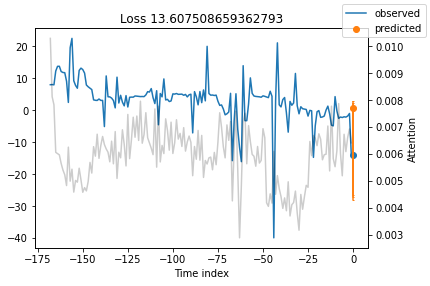

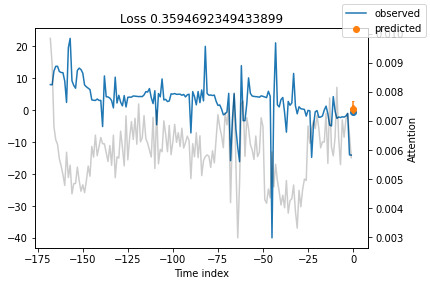

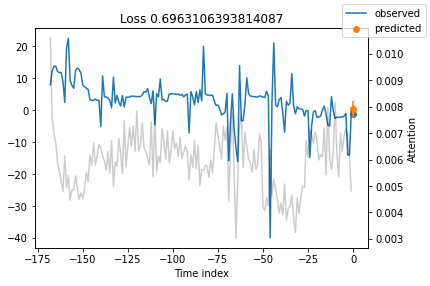

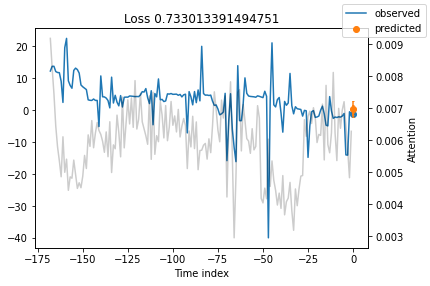

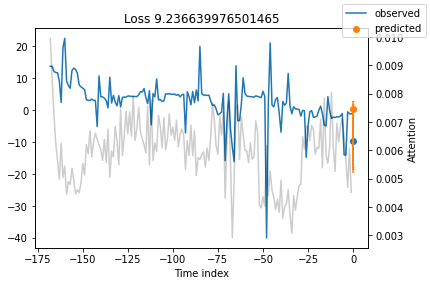

In [37]:
for idx in range(5):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

# Features Importance

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x792 with 1 Axes>,
 'decoder_variables': <Figure size 504x774 with 1 Axes>}

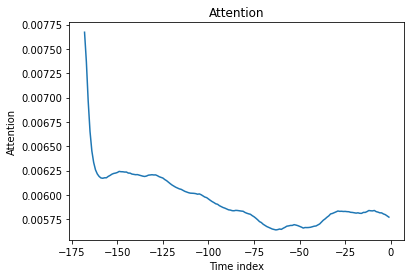

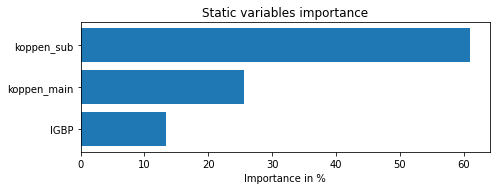

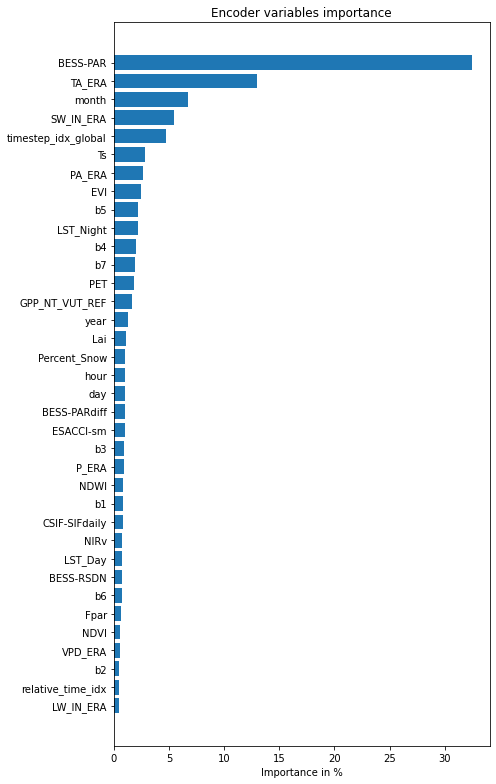

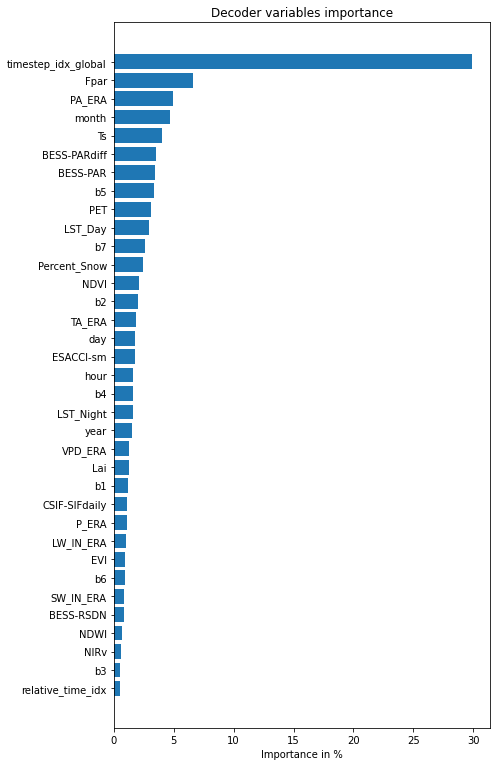

In [38]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

# Test with new sites

- Predict on new data
- Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.


- when we provide `best_tft.predict(new_prediction_data)` it only provides prediction data
- when we provide `best_tft.predict(new_prediction_data, mode="raw", return_x=True)` it provides in details


In [72]:
test_sites

['CA-Cbo', 'ES-LM2', 'FR-Lam', 'US-AR1', 'US-GLE', 'US-Seg']

When we limit the period the number of sites become 6->5

In [80]:
test_sites = list(test_df["site_id"].unique())

# Subset train_df to save some time
print(f"Test Sites: {test_df['site_id'].unique()}")

# Subset the time series within sites to save more time (300 days)
test_df = test_df.loc[test_df['timestep_idx_global'] < 300, ].copy()

Test Sites: ['CA-Cbo' 'FR-Lam' 'US-AR1' 'US-GLE' 'US-Seg']


In [81]:
new_prediction_data = test_df

In [82]:
new_raw_predictions["prediction"]

tensor([[[-0.8444, -0.3760, -0.3817, -0.2580,  0.4670,  0.4243,  2.3135]],

        [[-1.3573, -0.7090,  0.0562,  0.5603,  1.1037,  2.3298,  3.0485]],

        [[-1.0514, -0.4143, -0.2425, -0.1140,  0.3936,  0.6369,  2.1734]],

        [[-1.5301, -0.7180,  0.0058,  0.2393,  0.4338,  1.4898,  2.1836]],

        [[-0.9245, -0.2914, -0.2564, -0.2572,  0.3391,  0.2149,  1.9368]]])

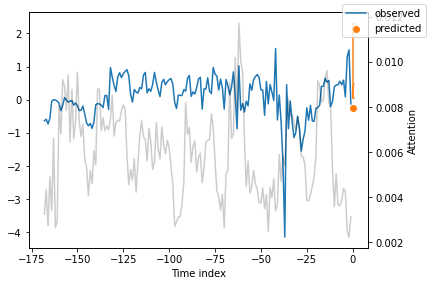

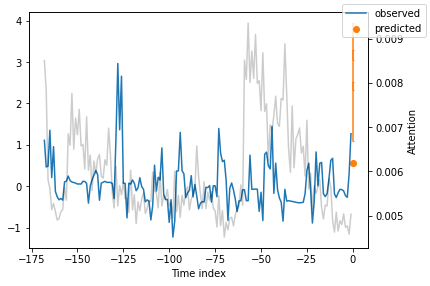

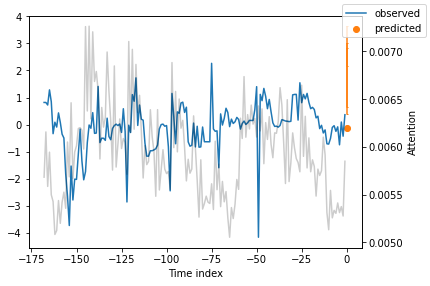

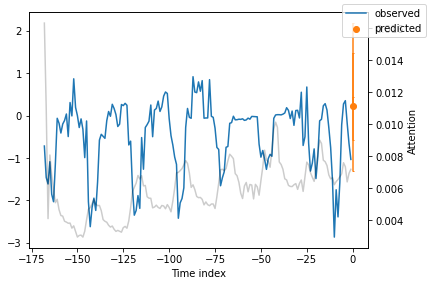

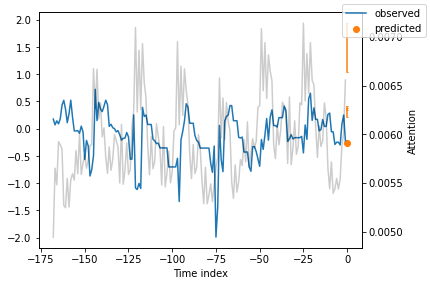

In [83]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(len(test_df["site_id"].unique())):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [67]:
new_raw_predictions.keys()

('prediction',
 'encoder_attention',
 'decoder_attention',
 'static_variables',
 'encoder_variables',
 'decoder_variables',
 'decoder_lengths',
 'encoder_lengths')

In [71]:
new_raw_predictions["prediction"]

tensor([[[-0.8444, -0.3760, -0.3817, -0.2580,  0.4670,  0.4243,  2.3135]],

        [[-1.3573, -0.7090,  0.0562,  0.5603,  1.1037,  2.3298,  3.0485]],

        [[-1.0514, -0.4143, -0.2425, -0.1140,  0.3936,  0.6369,  2.1734]],

        [[-1.5301, -0.7180,  0.0058,  0.2393,  0.4338,  1.4898,  2.1836]],

        [[-0.9245, -0.2914, -0.2564, -0.2572,  0.3391,  0.2149,  1.9368]]])

In [86]:
best_tft.predict(new_prediction_data, mode="raw", return_x=True)


tensor([[-0.2580],
        [ 0.5603],
        [-0.1140],
        [ 0.2393],
        [-0.2572]])

In [95]:
testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=True, stop_randomization=True)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_tft.predict(test_dataloader)

mae = (actuals - predictions).abs().mean()
print(f"Test MAE: {mae}")

# Derive Val RMSE
criterion = nn.MSELoss()
rmse = torch.sqrt(criterion(actuals, predictions))
print(f"Test RMSE: {rmse}")

Test MAE: 0.6864688992500305
Test RMSE: 0.8264555931091309


# Actuals vs predictions by variables
- Checking how the model performs across different slices of the data allows us to detect weaknesses. 
- Plotted below are the means of predictions vs actuals across each variable divided into 100 bins using the Now, we can directly predict on the generated data using the `calculate_prediction_actual_by_variable(){` and `plot_prediction_actual_by_variable()` methods. The gray bars denote the frequency of the variable by bin, i.e. are a histogram.


TypeError: ignored

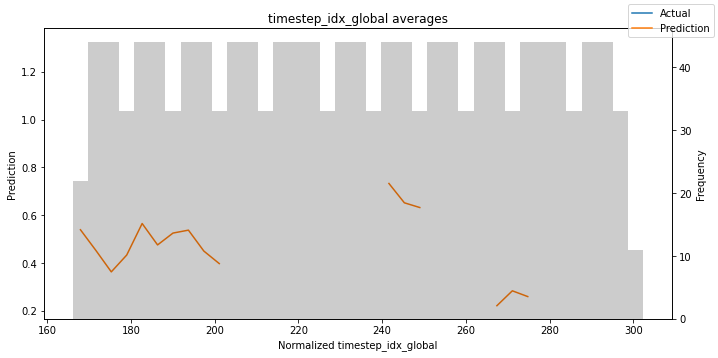

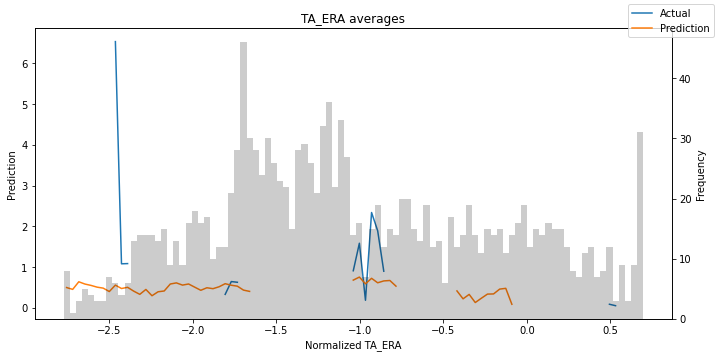

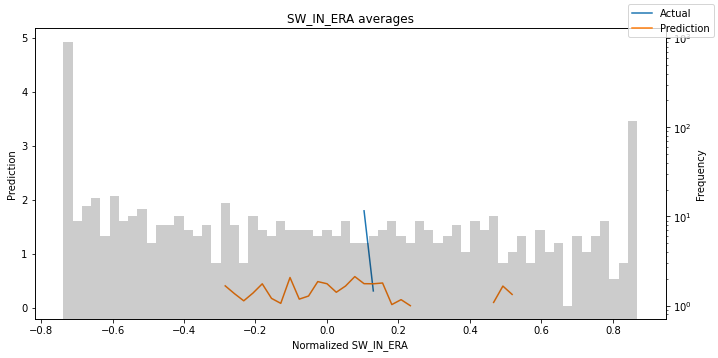

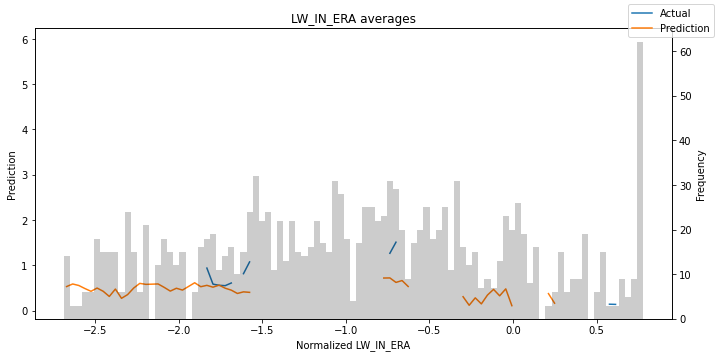

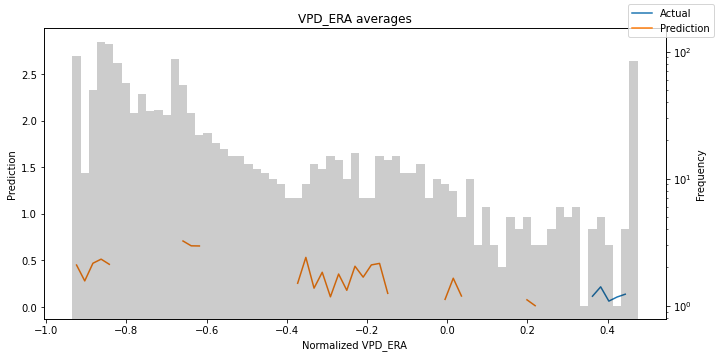

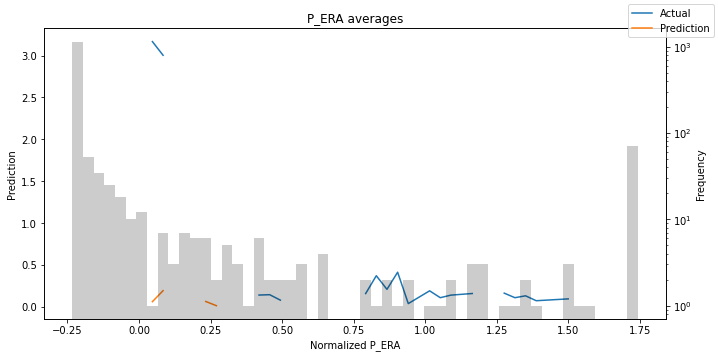

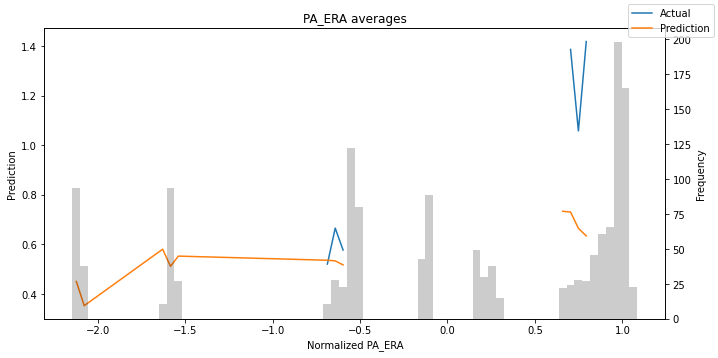

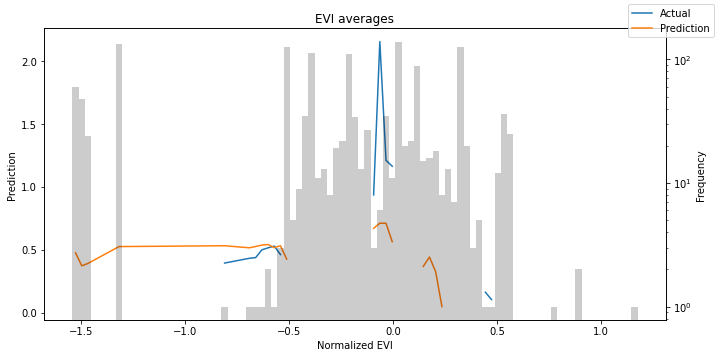

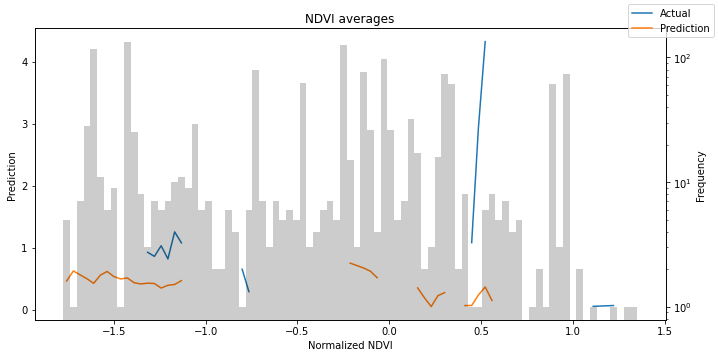

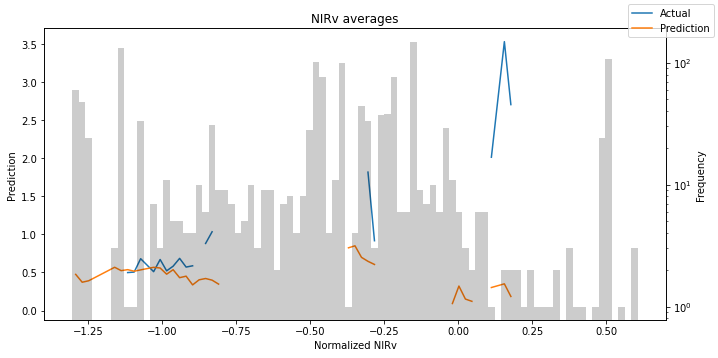

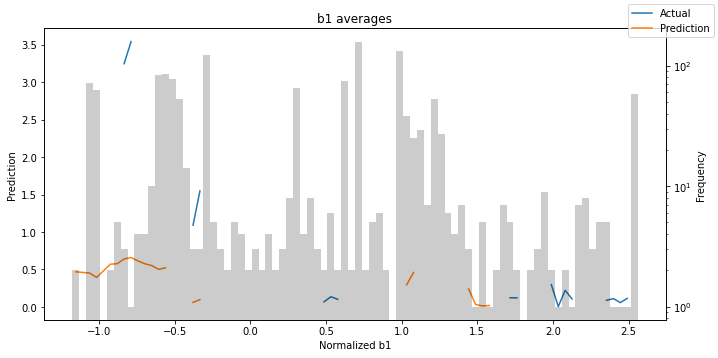

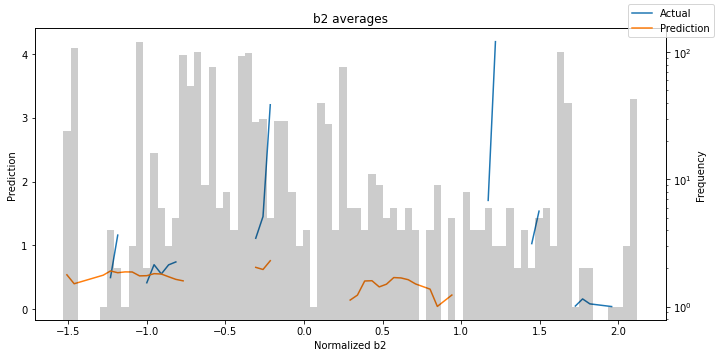

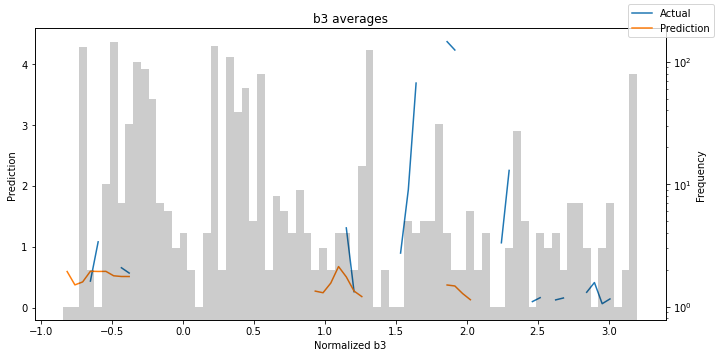

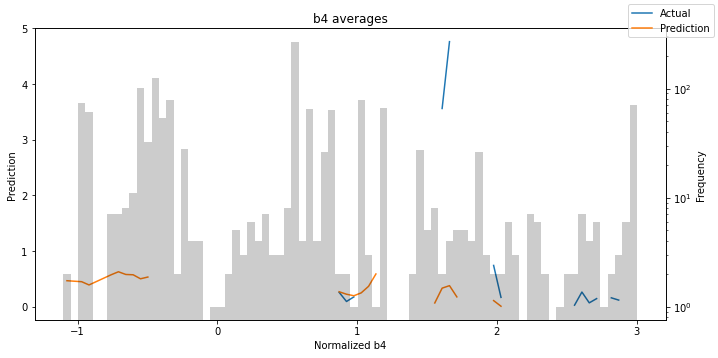

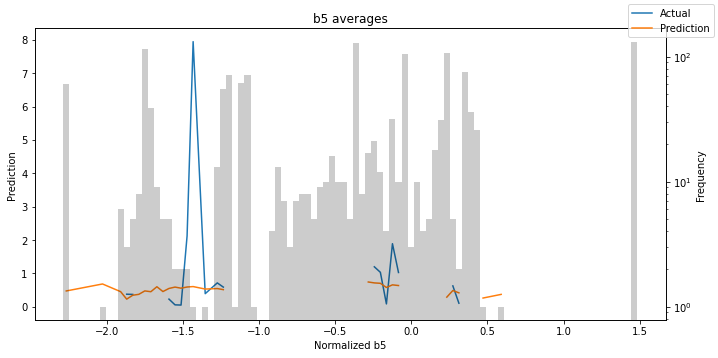

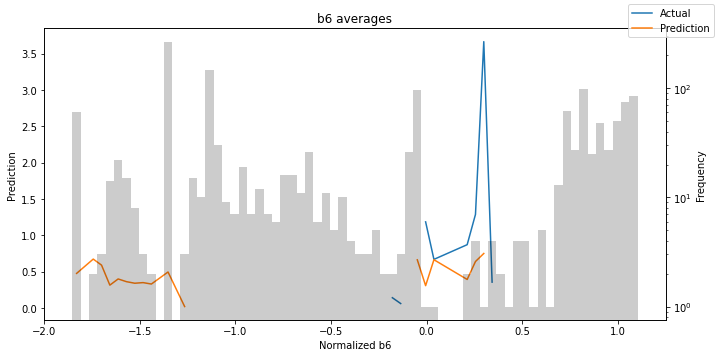

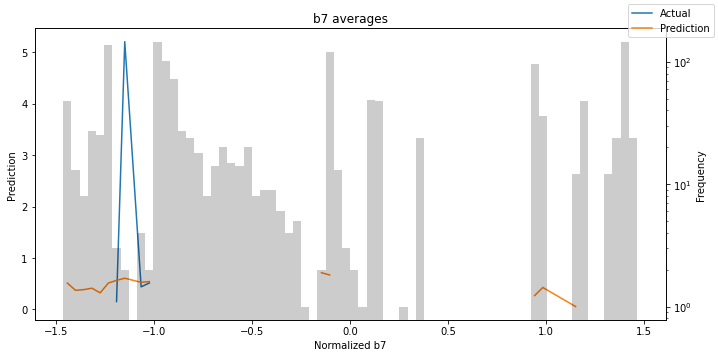

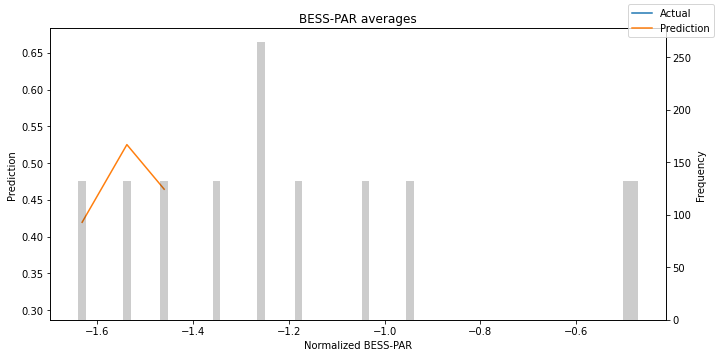

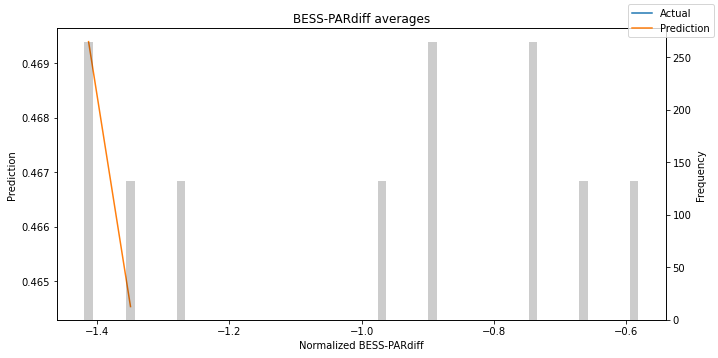

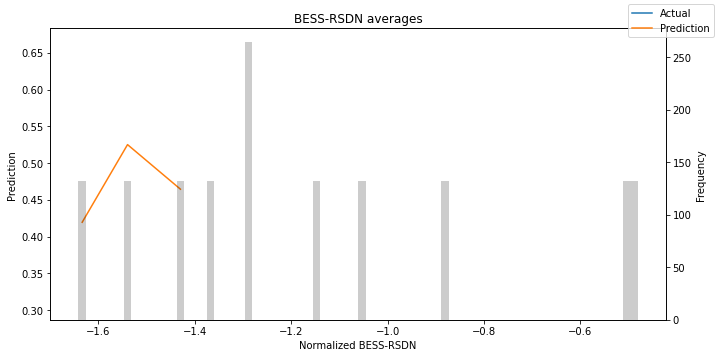

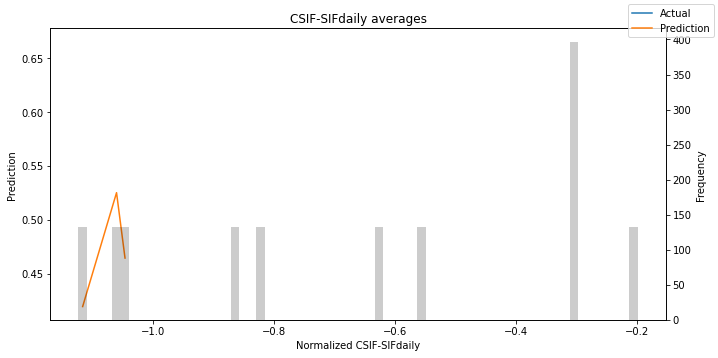

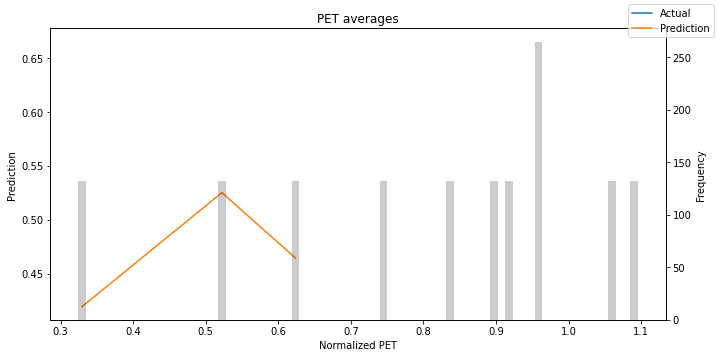

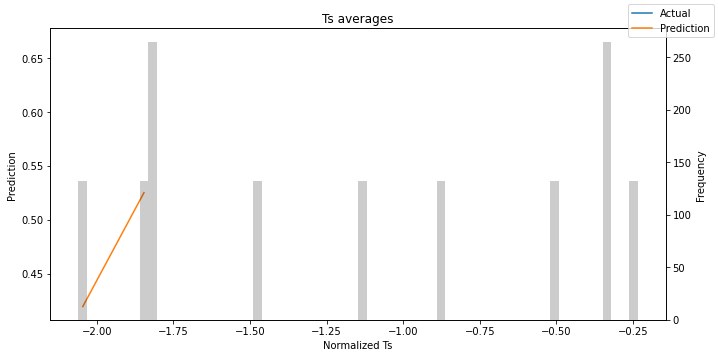

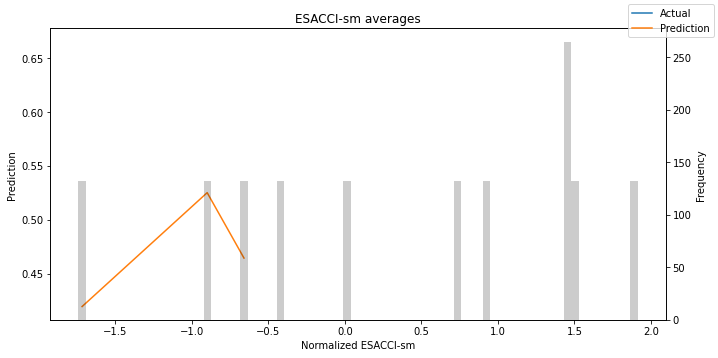

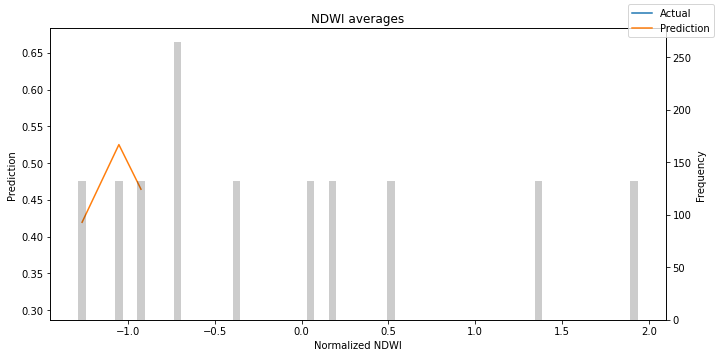

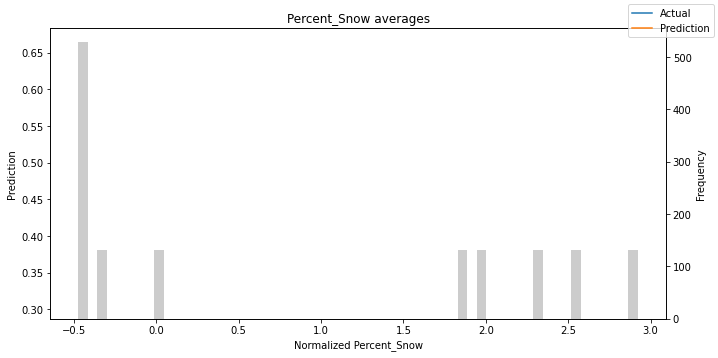

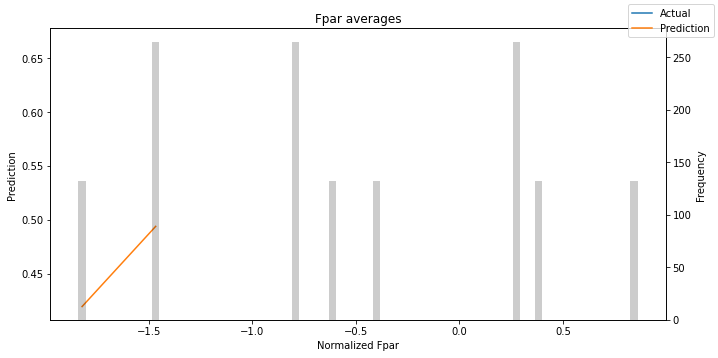

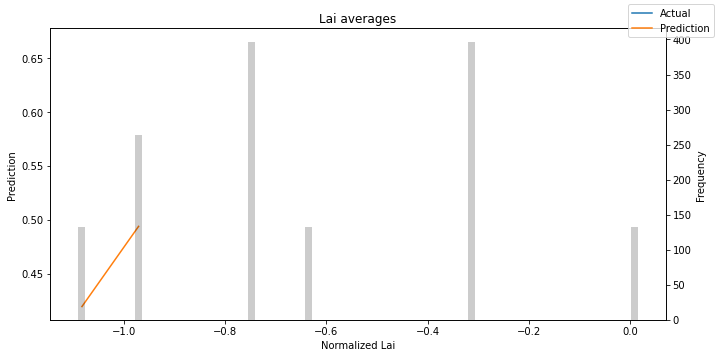

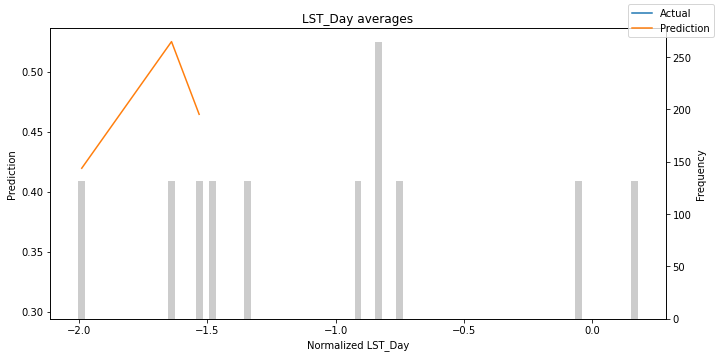

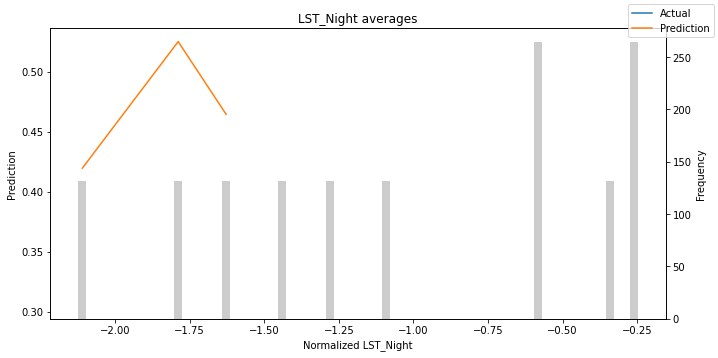

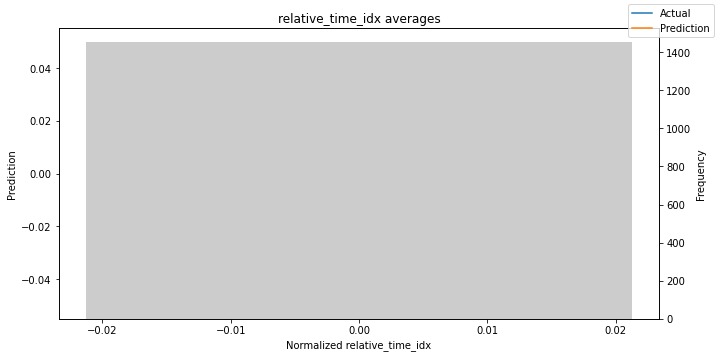

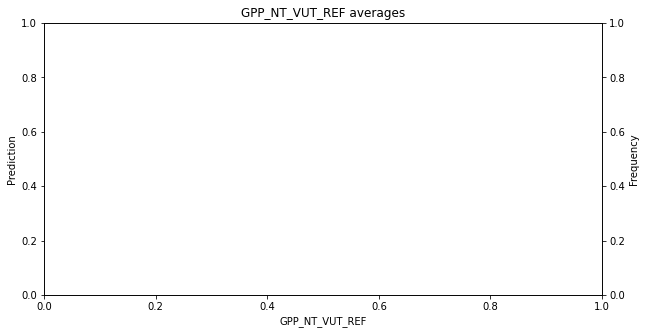

In [97]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);